# Hands on with PyMC
Let's practice everything we have learned this morning. We will be using the `PyMC` library to do Bayesian 
inference and explore posterior distributions. 

We only workout the case of two variants A and B with **Value conversions**. For now, we don't use real data yet and simply assume synthetic trials and successes.

## Value Conversions



Now what if we wanted to compare A/B test variants in terms of how much revenue they generate, and/or estimate how much additional revenue a winning variant brings? We can’t use a Beta-Binomial model for this, as the possible values for each visitor are now in the range [0, Inf).

The revenue generated by an individual visitor is 

revenue = probability of paying at all * mean amount spent when paying.

- As before, Bernoulli conversions follow Beta-Binomial.
- mean purchase amount follow a Gamma prior (which is also a conjugate prior to the Gamma likelihood)

- conversion of an individual follows Bernoulli(theta)
- amount spent by an individual follows Exp(lambda)

From N flips, z are head, which lead to payment. payment ~ gamma(z,lambda). Payment of each person ~Exp(lambda)

our **prior** about conversion chance of a user:

$$\theta_A \sim \theta_B \sim \mathrm{Beta}(\alpha_1, \beta_1)$$

our **prior** about the amount spent by a user:

$$\lambda_A \sim \lambda_B \sim \mathrm{Gamma}(\alpha_2, \beta_2)$$


conversion chance **Likelihood**:

$$conv_A \sim \mathrm{Binomial}(N_A, \theta_A)$$ 
$$conv_B \sim \mathrm{Binomial}(N_B, \theta_B)$$

amount spent **Likelihood**:

$$rev_A \sim \mathrm{Gamma}(conv_A, \lambda_A)$$
$$rev_B \sim \mathrm{Gamma}(conv_B, \lambda_B)$$

Average spending by two types_

$$\mu_A =  \dfrac{\theta_A}{\lambda_A}$$
$$\mu_B =  \dfrac{\theta_B}{\lambda_B}$$

uplift:

$$\mathrm{reluplift}_B = \mu_B / \mu_A - 1$$

$\mu$ here represents the average revenue per visitor, including those who don't make a purchase. This is the best way to capture the overall revenue effect - some variants may increase the average sales value, but reduce the proportion of visitors that pay at all (e.g. if we promoted more expensive items on the landing page).

Below we put the model setup into code and perform prior predictive checks.


In [5]:
# Load libraries
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm

In [6]:
# Set random seed
rng = np.random.default_rng(1)
# Set plotting style
plotting_defaults = dict(bins=50,kind="hist",textsize=8,)

## Your First Try

In [7]:
# as before we have variants A and B
variants  = ['A', 'B']

In [97]:
# let's define the revenue data
# each variant has 1000 visitors 
visitors      = [1000, 1000]

# 100 of which leads to purchase, i.e. conversion rate is 10%
purchased     = [100, 100]

# each purchase is worth 10, i.e. mean purchase is 10
total_revenue = [1000, 1000]

In [5]:
# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [9000, 900]

In [6]:
# let's define parameters for a weak prior for the conversion rates
weak_alpha, weak_beta = [5000, 5000]

In [110]:
with pm.Model() as example_model:

    #------------------------------------------------conversion rate model
    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood of observations
    converted = pm.Binomial("converted", 
                            n        = visitors,      # total visitors
                            observed = purchased,     # total visitors converted
                            p        = theta,         # chance they convert
                            shape    = 2)  
    
    #------------------------------------------------revenue model
    # Priors for unknown model parameters
    lamda = pm.Gamma( "lamda", 
                    alpha = purchase_alpha,
                    beta  = purchase_beta,
                    shape = 2)
    
    # Likelihood of observations
    revenue = pm.Gamma("revenue", 
                        alpha    = purchased,            # total visitors converted
                        observed = total_revenue, 
                        beta     = lamda, 
                        shape    = 2)        
    
    # get the revenue per visitor
    revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta / lamda)

    #------------------------------------------------relative uplifts
    # get the uplifts
    theta_uplift = pm.Deterministic(f"theta uplift", theta[1] / theta[0] - 1)
    lamda_uplift = pm.Deterministic(f"lamda uplift", (1 / lamda[1]) / (1 / lamda[0]) - 1)
    uplift       = pm.Deterministic(f"uplift", revenue_per_visitor[1] / revenue_per_visitor[0] - 1)

    #------------------------------------------------posterior
    # draw posterior samples
    trace = pm.sample(draws=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


In [99]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(5e+03, 5e+03),
 lamda ~ Gamma(9e+03, f()),
 revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [100]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs  

[converted ~ Binomial(<constant>, theta),
 revenue ~ Gamma(<constant>, f(lamda))]

In [101]:
# Check the deterministic random variable:
example_model.deterministics

[revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [102]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [103]:
# find out the shape of all trace.posterior variables
for var in trace.posterior:
    print(var, trace.posterior[var].shape)

theta (4, 10000, 2)
lamda (4, 10000, 2)
revenue_per_visitor (4, 10000, 2)
theta uplift (4, 10000)
lamda uplift (4, 10000)
uplift (4, 10000)


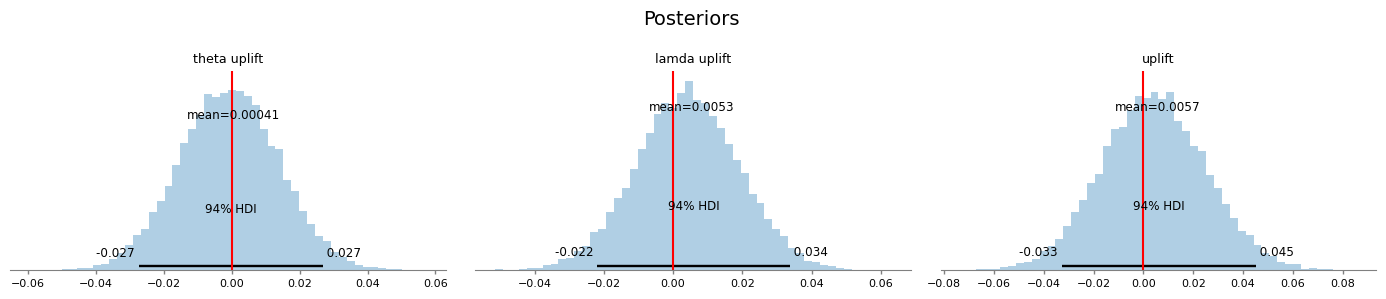

In [111]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

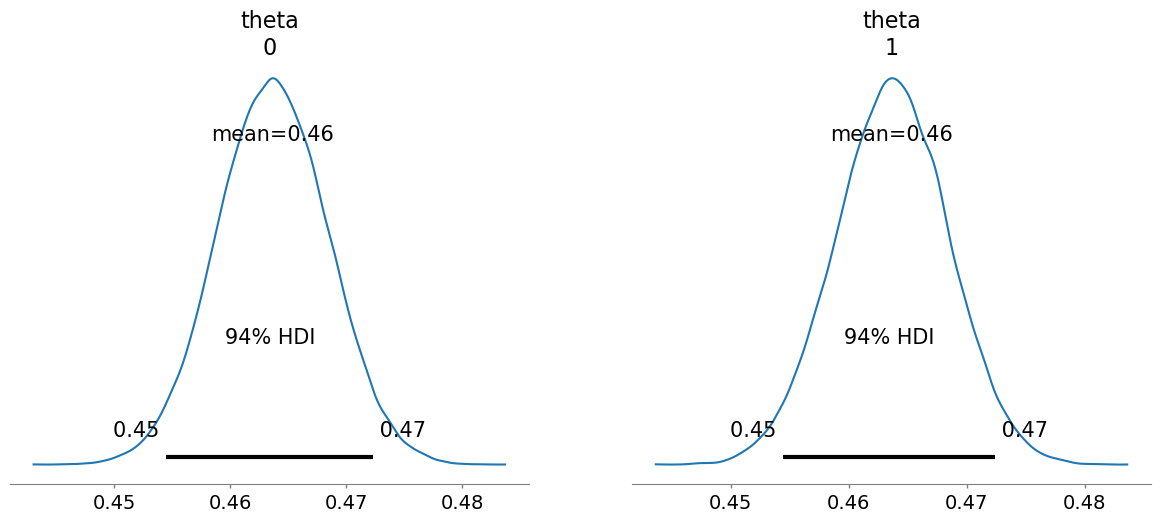

In [105]:
# plot the posterior of the conversion rates
az.plot_posterior(trace, var_names=["theta"]);

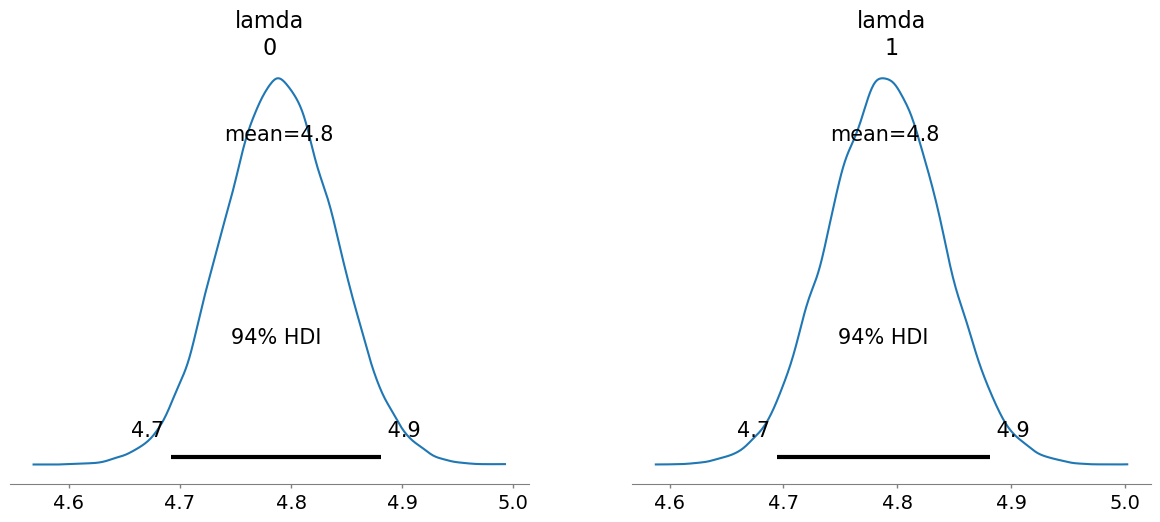

In [106]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["lamda"]);

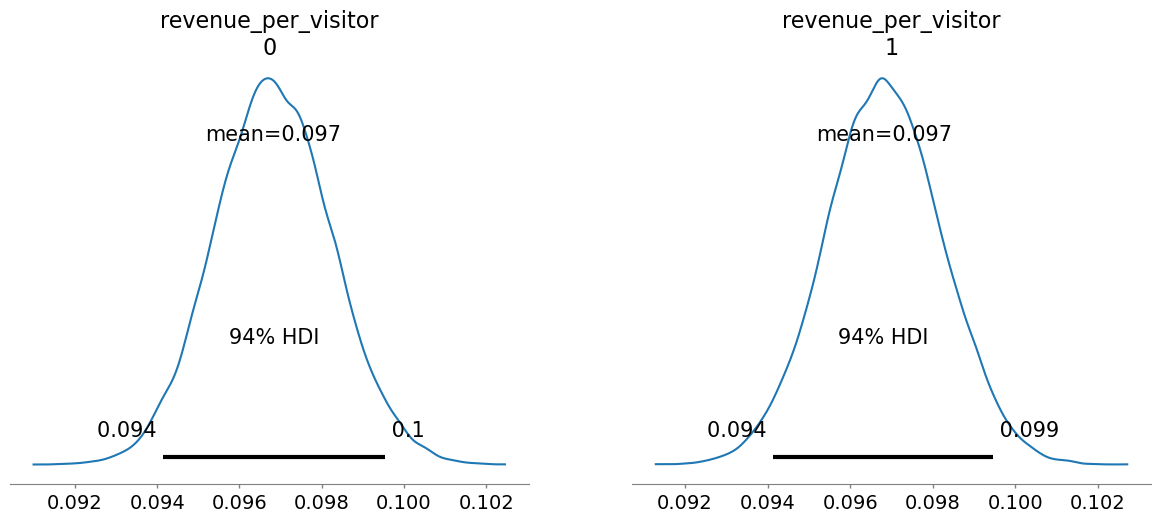

In [107]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["revenue_per_visitor"]);

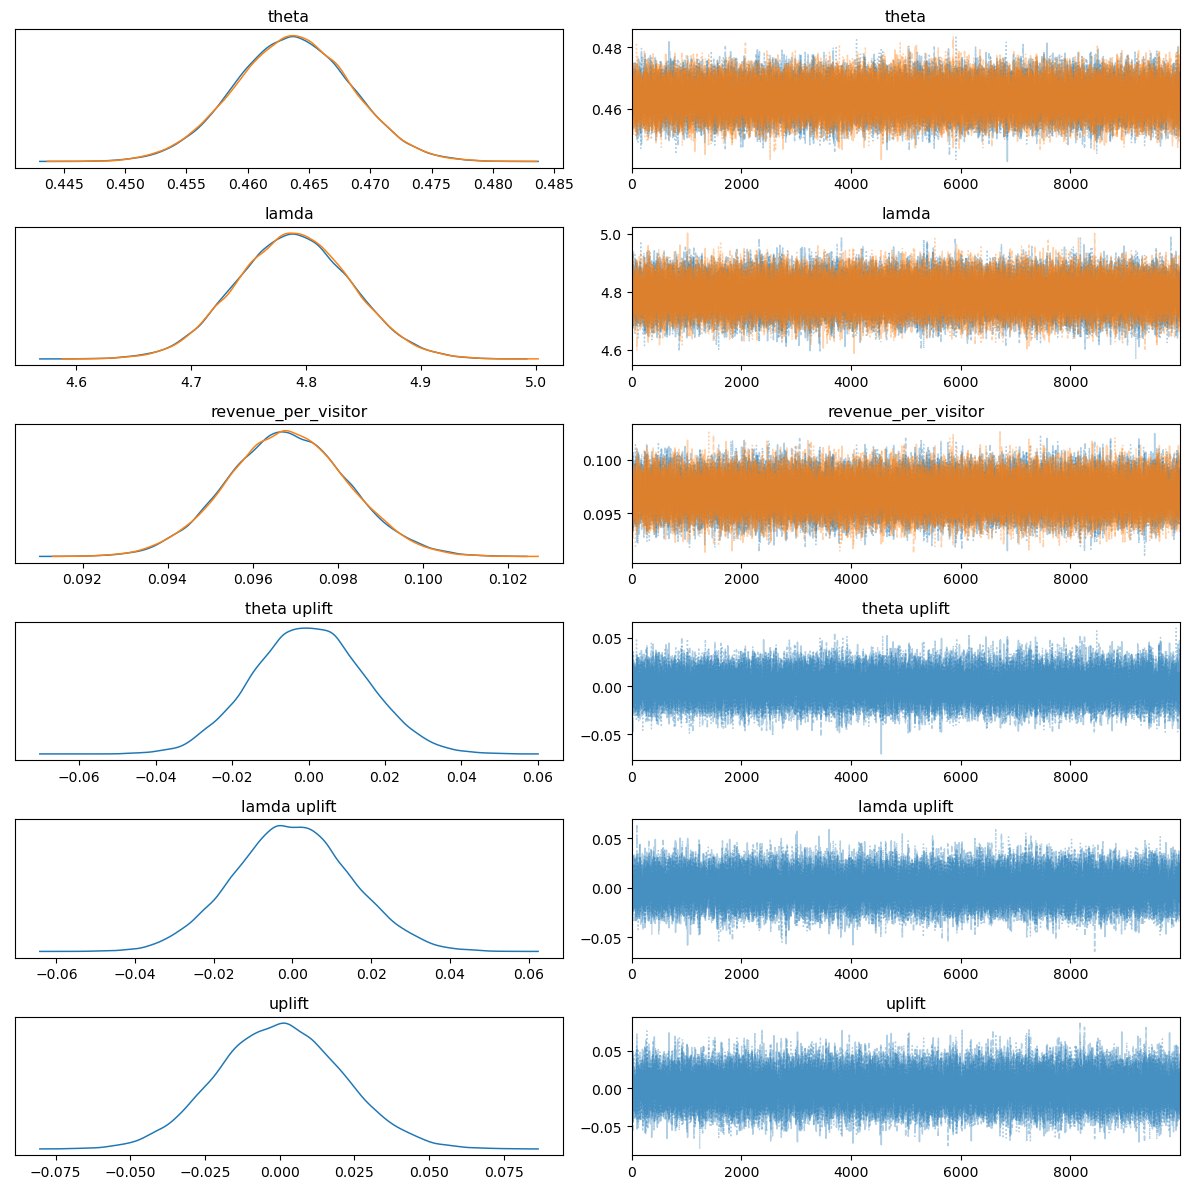

In [108]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your Second Try

Note that so far we have set up the number of `purchased` and `total_revenue` as absolute values. We will later change this to be a random variables.

In [37]:
%run -i tools.py

In [40]:
# let's increase the sample size to 100,000 
visitors = [100000, 100000]

# conversion_rates [10%, 8%]  
conversion_rates = [0.1, 0.08]

# mean_purchase 
mean_purchase    = [10, 12.5]

Lower propensity to purchase and higher mean purchase value, but overall same revenue per visitor.

In [45]:
visitors, purchased, total_revenue = get_data(variants, conversion_rates, mean_purchase, 100000)

simulated  100000  Bernoulli data based on  0.1 for variant  A
simulated  100000  Exponential data based on  10 for variant  A
simulated  100000  Bernoulli data based on  0.08 for variant  B
simulated  100000  Exponential data based on  12.5 for variant  B


,A,B
visitors,100000.0,100000.0
purchased,10233.0,8028.0
total_revenue,102771.0,99373.0


[RevenueData(visitors=100000.0, purchased=10233.0, total_revenue=102771.0271933957),
 RevenueData(visitors=100000.0, purchased=8028.0, total_revenue=99372.83483298615)]

In [42]:
# let's define parameters for a weak prior for the conversion rates
weak_alpha, weak_beta = [5000, 5000]

# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [9000, 900]

In [46]:
trace =  get_posterior2(beta_priors  = [weak_alpha, weak_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue
                        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


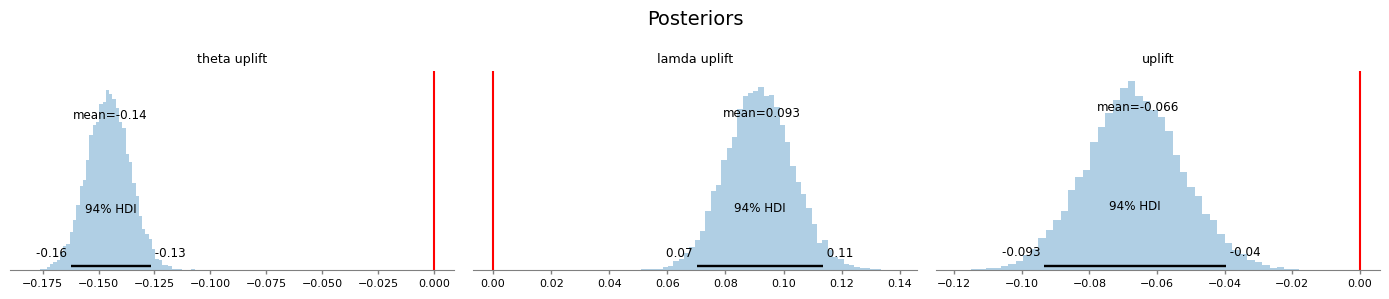

In [47]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

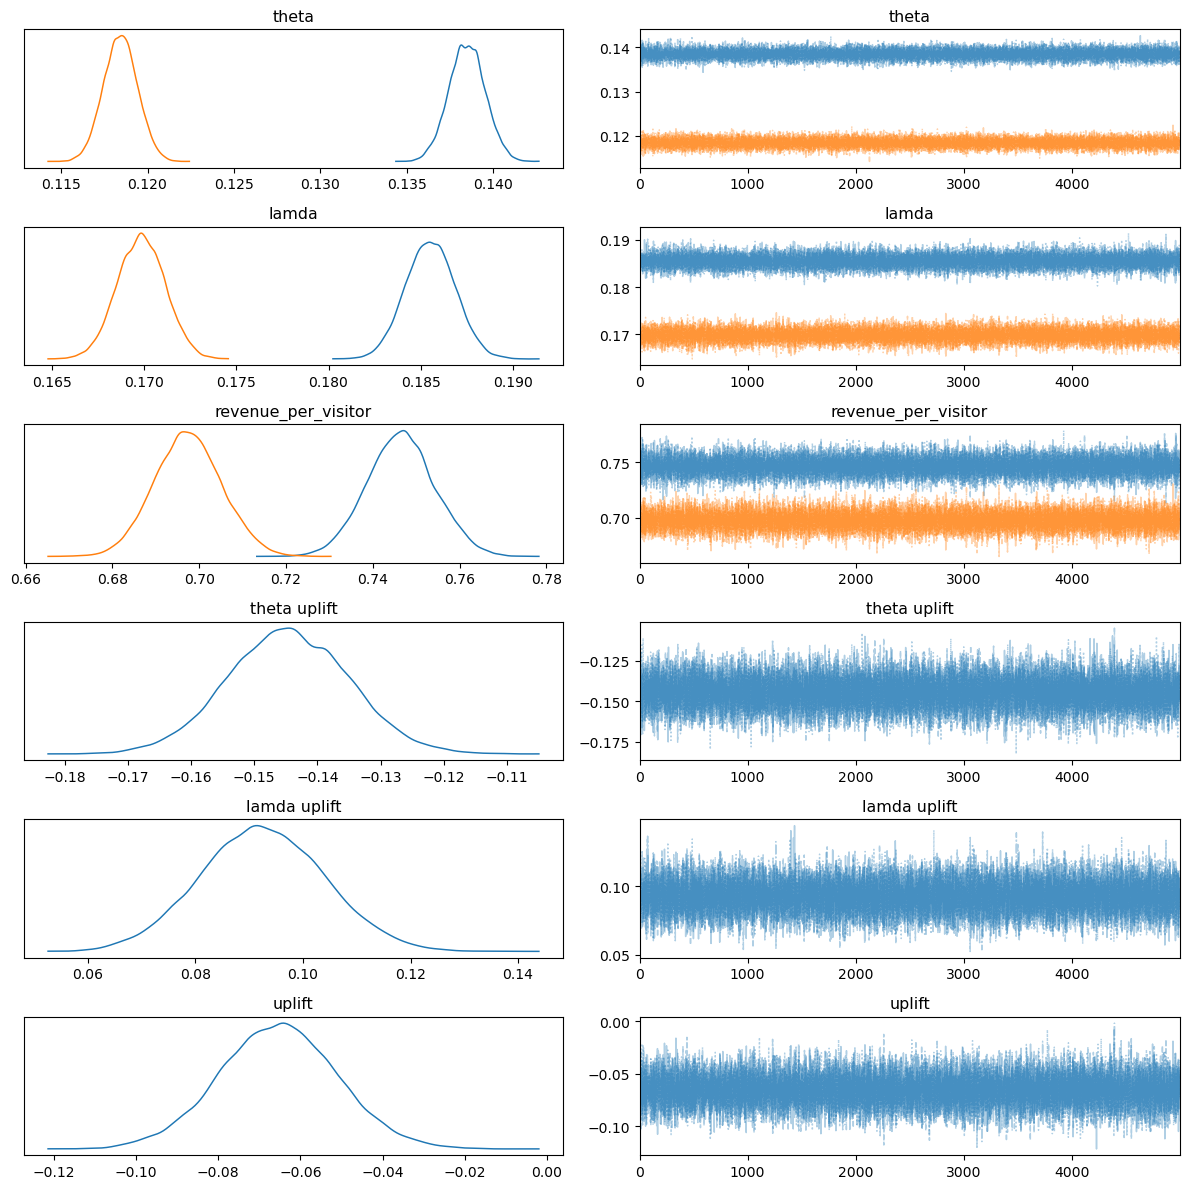

In [51]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your third Try
Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor

In [59]:
# conversion_rates [10%, 11%]  
conversion_rates = [0.1, 0.11]

# mean_purchase 
mean_purchase    = [10, 10.5]

In [60]:
visitors, purchased, total_revenue = get_data(variants, conversion_rates, mean_purchase, 100000)

simulated  100000  Bernoulli data based on  0.1 for variant  A
simulated  100000  Exponential data based on  10 for variant  A
simulated  100000  Bernoulli data based on  0.11 for variant  B
simulated  100000  Exponential data based on  10.5 for variant  B


,A,B
visitors,100000.0,100000.0
purchased,9942.0,11081.0
total_revenue,100275.0,115039.0


[RevenueData(visitors=100000.0, purchased=9942.0, total_revenue=100274.94543025384),
 RevenueData(visitors=100000.0, purchased=11081.0, total_revenue=115038.79587498658)]

In [61]:
trace =  get_posterior2(beta_priors  = [weak_alpha, weak_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue
                        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


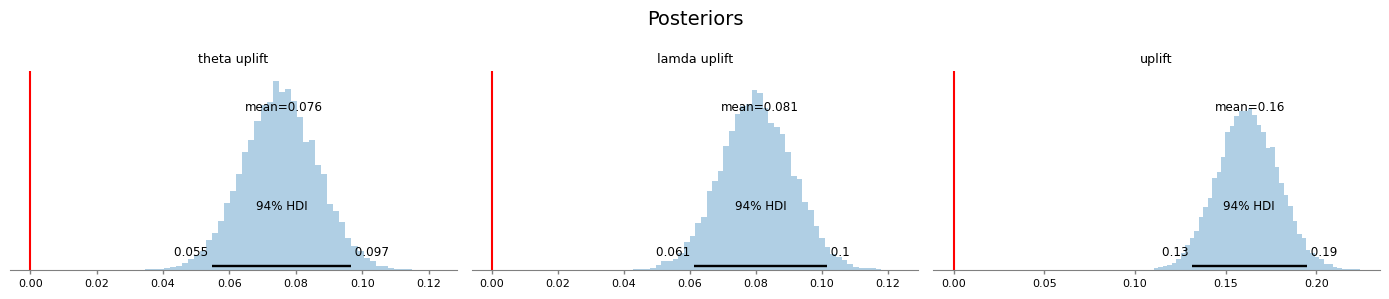

In [62]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()